In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
print(np.__version__)

1.16.5


In [2]:
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

### Define physical property functions

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

def column_density(Wave, Temp, Kappa, Flux, mu):

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    N = Flux / (mu * (mh*1.e3) * Kappa * B)

    return N

def number_density_sphere_pc( Mass_sol, Radius_pc, mu ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the number density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    n = Mass / (((4. / 3.)*np.pi) * mu * mh * Radius**3.0)

    # Convert to particles per cubic centimetre

    n = n / percm2perm

    return n

def mass_density_sphere( Mass_sol, Radius_pc ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the mass density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    rho = Mass / (((4. / 3.)*np.pi) * Radius**3.0)

    return rho

def tff_spherical( number_density, mu ):

    # Accepts a number density in units of particles per cubic centimetre and derives the free fall time in yrs

    mass_density = mu * mh * number_density * percm2perm

    tff = np.sqrt( (3. * np.pi) / (32. * G * mass_density) )

    tff = tff / sin1yr # free-fall time in years

    return tff
### Takes mass in solar masses and volume density constant in 1/cm^3 and gives radius in parsec.
def radius_from_mass_const_vol_density(Mass_solar,vol_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    vol_dens = vol_dens *  percm2perm
    #print vol_dens
    Radius_cubed = (Mass / (mu * mh * vol_dens)) / ((4. / 3.)*np.pi)
    #print Radius_cubed
    Radius_cm = Radius_cubed**(1./3.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc


def radius_from_mass_const_col_density(Mass_solar,col_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2

    Radius_sqrd = (Mass / (mu * mh * col_dens)) / (np.pi)
    #print Radius_cubed
    Radius_cm = Radius_sqrd**(1./2.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc
   
    
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm)#/100) 
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )

    Mass = Mass / msun

    return Mass

def flux_calc_submm( Wave, Temp, Kappa, Mass, Obj_Dist ):
    
    Mass = Mass * msun
    
    Obj_Dist = Obj_Dist * pc2cm

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )
    
    Integrated_Flux = (Mass*Kappa*B)/(Obj_Dist**2.)

    return Integrated_Flux


In [3]:
### Load tables

targetname = '_rms3e6_k14_dv3_dd1_dp17_pp6_pm2_gal_10-23-19'
targetid = targetname+'.fits'
path = os.path.expanduser('/Users/hph/cmzoom_catalog/catalog_acc/')
sma_path = path
herschel_path = path
catalog_path = path
figure_path = path
#plt.style.use('seaborn-colorblind')
#table_hdu = fits.open(path+'leaf_properties_tab'+targetname)
table_hdu = fits.open(path+'master_tab'+targetid)

mtable = table_hdu[1].data
catalog = Table.read(path+'master_tab'+targetid)


### Grab columns of interest
tff_spherical = table_hdu[1].data['tff']
Column_N = table_hdu[1].data['N']
Vol_n = table_hdu[1].data['n']
mass = table_hdu[1].data['mass']
mass_bgsub = table_hdu[1].data['mass_bgsub']
r_eff_as = table_hdu[1].data['r_eff']
r_eff_pc = r_eff_as * arcsec2pc
noise_JySr = table_hdu[1].data['noise']
noise_Jyas = noise_JySr / as2persr
noise = noise_Jyas * table_hdu[1].data['area_exact']
flux_integrated = table_hdu[1].data['flux_integrated']
noise_mass = mass_calc_submm(Wave, dustTemp, Kappa, noise, distance)
noise_mass = noise_mass*u.Msun

In [4]:
rms = fits.open('/Users/hph/cmzoom_catalog/catalog_acc/noisemap_tests/CMZoom_noisemap_JySr_k14_final.fits')
region_mask = fits.open('/Users/hph/cmzoom_catalog/Continuum/CMZoom_Mask_new.fits')
rms[0].data.shape
mask_data = region_mask[0].data

In [5]:
np.where(np.isnan(mask_data))

(array([], dtype=int64), array([], dtype=int64))

In [6]:
w = wcs.WCS(path+'CMZoom_continuum_mosaic_no_SgrA.fits').celestial

xglon = w.wcs_world2pix(catalog['glon'],catalog['glat'],0)[0]
yglat = w.wcs_world2pix(catalog['glon'],catalog['glat'],0)[1]

In [13]:
sgrb2 = np.zeros_like(xglon)
for i in range(len(sgrb2)):
    if mask_data[int(yglat[i]),int(xglon[i])]==10:
        sgrb2[i]=1

In [14]:
sgrb2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

(2,)
(2,)


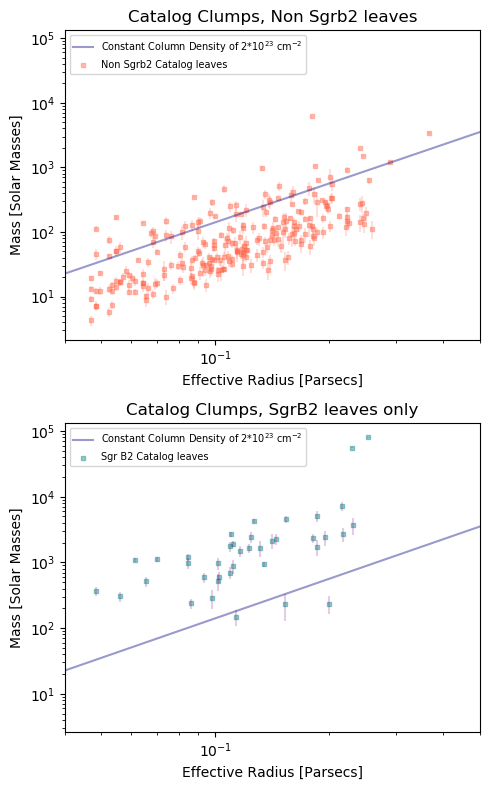

In [17]:
## side by side
nsgrb2 = (sgrb2==False)
ysgrb2 = (sgrb2==True)
plt.close()
plt.rcParams.update({'font.size': 10}) #set fontsize
noise_mass_arr = np.array(noise_mass)

#radius_vals = radius_from_mass_const_col_density(mass,2.1*10**23)
mass_bin = np.array([min(mass),max(mass)])
print( mass_bin.shape)
radius_vals = radius_from_mass_const_col_density(mass_bin,2.0*10**23)
print( radius_vals.shape)

f = plt.figure(figsize=(5,8))

#plt.xlabel('Effective Radius [Parsecs]')
#plt.ylabel('Mass [Solar Masses]')

ax1 = f.add_subplot(211)
ax1.set_title('Catalog Clumps, Non Sgrb2 leaves')
ax1.scatter(r_eff_pc[nsgrb2], mass[nsgrb2],s=10, color='tomato',alpha=.4,marker='s',label='Non Sgrb2 Catalog leaves')
ax1.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 2*10$^{23}$ cm$^{-2}$',alpha=0.4)
ax1.errorbar(x=r_eff_pc[nsgrb2], y=mass[nsgrb2], yerr=noise_mass_arr[nsgrb2], ls='none',color='tomato',alpha=0.2)

legend = ax1.legend(loc='upper left', shadow=False, fontsize=7)#'x-large')

ax1.set_xlabel('Effective Radius [Parsecs]')
ax1.set_ylabel('Mass [Solar Masses]')
ax1.set_xlim(4e-2,0.5)

ax2 = f.add_subplot(212)
ax2.set_title('Catalog Clumps, SgrB2 leaves only')
ax2.scatter(r_eff_pc[ysgrb2],mass[ysgrb2], s=10, color='teal',alpha=.4,marker='s',label='Sgr B2 Catalog leaves')
ax2.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 2*10$^{23}$ cm$^{-2}$',alpha=0.4)
ax2.errorbar(x=r_eff_pc[ysgrb2], y=mass[ysgrb2], yerr=noise_mass_arr[ysgrb2], ls='none',color='purple',alpha=0.2)
legend = ax2.legend(loc='upper left', shadow=False, fontsize=7)#'x-large')

ax2.set_xlabel('Effective Radius [Parsecs]')
ax2.set_ylabel('Mass [Solar Masses]')
#ax2.set_ylim(1e-2,2e5)
ax2.set_xlim(4e-2,0.5)


ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")

#plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis


plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'sgrb2_mass_radius'+targetname+'.pdf',
            format='pdf', dpi=100, bbox_inches='tight')
plt.show()

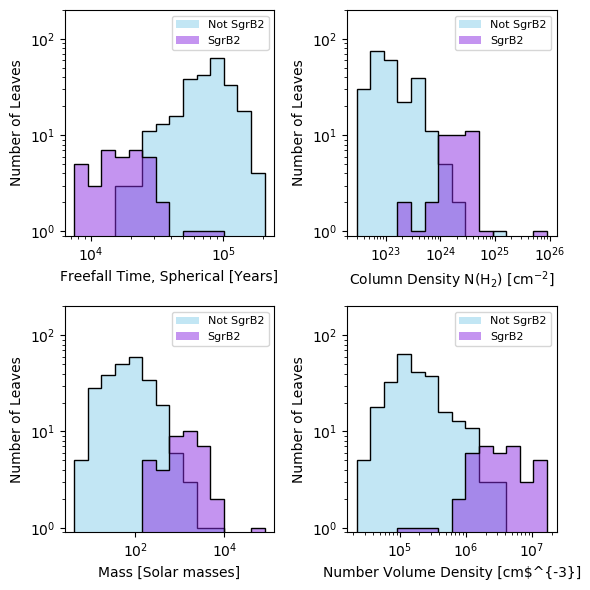

In [29]:
#########################################################
### Histograms but with SgrB2 separation
#########################################################
rlim = 0.12
sgrb2cond = (sgrb2==1)
nsgrb2cond = (sgrb2==0)
tff=catalog['tff']

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Leaves')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff), max(tff)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff[nsgrb2cond],
                   tff_logbins, color='skyblue',alpha=0.5, log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[0,0].hist(tff[nsgrb2cond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[0,0].hist(tff[sgrb2cond],
                   tff_logbins, color='blueviolet',alpha=0.5, log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[0,0].hist(tff[sgrb2cond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='best', shadow=False, fontsize=8)
axarr[0,0].set_ylim(0.9,200)

####
axarr[0,1].set_ylabel('Number of Leaves')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N), max(Column_N)
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)
h1,l1,p1 = axarr[0,1].hist(Column_N[nsgrb2cond],
                   N_logbins, color='skyblue',alpha=0.5, log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[0,1].hist(Column_N[nsgrb2cond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[0,1].hist(Column_N[sgrb2cond],
                   N_logbins, color='blueviolet',alpha=0.5, log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[0,1].hist(Column_N[sgrb2cond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='best', shadow=False, fontsize=8)
axarr[0,1].set_ylim(0.9,200)

####
axarr[1,0].set_ylabel('Number of Leaves')
axarr[1,0].set_xlabel('Mass [Solar masses]')


massmin, massmax = min(mass), max(mass)
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass[nsgrb2cond],
                   logbins, color='skyblue',alpha=0.5, log=True,
                   label='Not SgrB2')
h12,l1,p1 = axarr[1,0].hist(mass[nsgrb2cond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)
h12,l1,p1 = axarr[1,0].hist(mass[sgrb2cond],
                   logbins, color='blueviolet',alpha=0.5, log=True,
                   label='SgrB2')
h12,l1,p1 = axarr[1,0].hist(mass[sgrb2cond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='best', shadow=False, fontsize=8)
axarr[1,0].set_ylim(0.9,200)

####
# axarr[1,1].set_ylabel('Number of Pixels')
# axarr[1,1].set_xlabel('Effective Radius [pc]')
# reffmin, reffmax = min(r_eff_pc), max(r_eff_pc)
# reff_linbins = np.linspace(reffmin, reffmax,15)
# h1,l1,p1 = axarr[1,1].hist(r_eff_pc,
#                    reff_linbins, color='mediumorchid',alpha=0.7, log=True,
#                    label='SMA Clumps')
# h1,l1,p1 = axarr[1,1].hist(r_eff_pc,
#                    reff_linbins, color='k',alpha=1.0,histtype='step', log=True)

#axarr[1,1].set_xscale("log")
####
####
axarr[1,1].set_ylabel('Number of Leaves')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}]')
nmin, nmax = min(Vol_n), max(Vol_n)
h1,l1,p1 = axarr[1,1].hist(Vol_n[nsgrb2cond],
                   n_logbins, color='skyblue',alpha=0.5, log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[1,1].hist(Vol_n[nsgrb2cond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[sgrb2cond],
                   n_logbins, color='blueviolet',alpha=0.5, log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[1,1].hist(Vol_n[sgrb2cond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,1].set_xscale("log")
axarr[1,1].legend(loc='best', shadow=False, fontsize=8)
axarr[1,1].set_ylim(0.9,200)

####

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'sgrb2_4panel'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()




In [ ]:
### Make figure of column density
catalog = table_hdu[1].data
column_file = os.path.join(herschel_path, 'column_properunits_conv36_source_only.fits')
sma_file = os.path.join(sma_path, 'CMZoom_continuum_mosaic_no_SgrA.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                           column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')
colwcs = wcs.WCS(column_fh[0].header)
pix_sgrb2 = colwcs.wcs_world2pix(catalog['glon'][sgrb2cond], catalog['glat'][sgrb2cond], 0)
pix_nsgrb2 = colwcs.wcs_world2pix(catalog['glon'][nsgrb2cond], catalog['glat'][nsgrb2cond], 0)
column_dens_sgrb2 = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]
column_dens_nsgrb2 = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]

# column density file handle
column_fh = fits.open(column_file)
column_masked = column_fh[0].data
column_masked[~smaobserved_projto_herschel] = np.nan

sb2_mask = pyregion.open(os.path.join('/Users/hph/Dropbox/CMZoom_Data/prototype_catalog/', 
                                      'sgrb2mask.reg')).get_mask(column_fh[0])

colmin = np.nanmin(column_masked[~sb2_mask])
colmax = np.nanmax(column_masked[~sb2_mask])


smasourcemask = np.zeros_like(smaobserved_projto_herschel, dtype='bool')

# for each source, "mask" a region that is within a herschel beam as "this region contains a source"
herschel_beamsize_pixels = (25*u.arcsec / np.mean(wcs.utils.proj_plane_pixel_scales(colwcs)*u.deg)).decompose()

# make a small radial mask
npix = int(np.ceil(herschel_beamsize_pixels))
yy,xx = np.indices([npix*2]*2, dtype='float')
rad = ((yy-npix+0.5)**2 + (xx-npix+0.5)**2)**0.5
radmask = rad < herschel_beamsize_pixels

pb = ProgressBar(len(catalog))
for row,(cx,cy) in zip(catalog, zip(*pix)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    pb.update()

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('seaborn-colorblind')
#sns.set_style("whitegrid", {'axes.grid' : False})

# Plot Histogram
plt.rcParams.update({'font.size': 10}) #set fontsize
histfig = plt.figure(3,figsize=(5,5))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Pixels')
plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
#plt.legend(loc='upper left', shadow=False, fontsize=18)

#bins = np.logspace(22.9,23.9,100)
binnum = 30

linbins = np.linspace(colmin, colmax,binnum)
logbins = np.logspace(np.log10(colmin), np.log10(colmax),binnum)
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=0.5, log=False,
                   label='Full cloud')
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=1.0, log=False,histtype='step')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='blue',
                   label='SMA Sources')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='k', histtype='step')

ax3 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
p3 = line_frac = ax3.plot(midpts, h2/h1, linestyle='-', color='k', 
                     linewidth=2.0, zorder=-21,label='Fraction of pixels with SMA Sources')
ax3.set_ylabel("Fraction of pixels with SMA Sources")
ax3.set_ylim(0,1)
fill = ax3.fill_between(midpts,h2/h1, color='orange',alpha=0.1)
ax3.set_label('Fraction of pixels with SMA Sources')
#ax.legend(line_frac,'Fraction of pixels with SMA Sources')
#ax3.legend(loc='upper right', shadow=False, fontsize=18)

vx, vy = [2e23,2e23],[0,1]

p4 = ax3.plot(vx,vy,linestyle='--',linewidth=4.0,color='tomato', label='N(H$_2$)= 2e23 cm$^{-2}$')
ax.set_xscale("log")


ax.set_xlim(1.18e22, colmax-1e22)

ax.set_ylim(1,1400)
#plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis
ax.tick_params(axis='both',which='major',direction='in',length=5)
ax.tick_params(axis='both',which='minor',direction='out',length=5)
ax3.tick_params(axis='both',which='major',direction='in',length=5)

#labs = [h1.get_label(),h2.get_label(),p3.get_label(),p4.get_label()]
plt.rcParams.update({'font.size': 8})
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='k',alpha=0.3, edgecolor='None',
                         label='All Herschel Pixels'),
                   Patch(facecolor='b',alpha=0.8, edgecolor='None',
                         label='Herschel Pixels with SMA Sources'),
                   Patch(facecolor='#FEF5E7',alpha=0.99, edgecolor='k',
                         label='Percent of Herschel pixels with SMA Sources'),
                   Line2D([0], [0], color='tomato', lw=4, ls='--', label='N(H$_2$)= 2e23 cm$^{-2}$')]

ax.legend(handles=legend_elements, loc='upper left')

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
#plt.savefig(figure_path + 'column_histograms_log'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()